In [1]:
#!/usr/bin/env python3
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from scipy.stats import norm

# ==========================================
# PARAMETERS
# ==========================================
# Today's stock price (Spot price)
S0 = 100.0

# Strike price
E = 100.0

# Time to expiry: 1 year
T = 1                      # number of years
time_units = 252.0         # days in a working year
dt = (T - 0)/time_units   # timestep
sqrtdt = np.sqrt(dt)       # Compute this outside the loop to save computing it 
                           # at every timestep
time_range = np.arange(0, T+dt, dt)   # array of time units

# Volatility
sigma = 0.2 # 20% 

# Constant risk-free interest rate 
r = 0.05 # 5%

"""
Could also make volatility a stochastic variable.
Could also make interest rate a stochastic variable.

But I have run out of time... 
"""

# How many simulations to perform?
num_sims = np.array([
              10,
              100,
              500,
              750, 
              1000,
              5000,
              10000,
              50000,
              100000,
              250000,
              500000,
              750000,
              1000000,
              2500000,
              5000000,
              7500000,
              10000000,
])

In [2]:
# Arrays for data storage and post-processing

# Binary options
array_binary_call_errors = np.zeros(len(num_sims))
array_binary_put_errors  = np.zeros(len(num_sims))

array_binary_call_times = np.zeros(len(num_sims))
array_binary_put_times  = np.zeros(len(num_sims))


In [3]:
def percentage_difference(A, B):
    return np.abs(A-B) / ((A+B)/2.0) * 100.0

def percentage_error(A,B):
    return np.abs(A-B)/B *100.0

In [4]:
# ==========================================
# METHODS FOR BINARY OPTIONS
# ==========================================
def analytic_binary_call_value(S_0, E, r, v, T):
    """
    Closed form solution of the Black-Scholes equation
    for a binary call option
    """
    d_2 = (np.log(S_0/E) + (r - 0.5*v*v)*T) / (v*np.sqrt(T))
    value = np.exp(-r*T) * norm.cdf(d_2)
    return value

def analytic_binary_put_value(S_0, E, r, v, T):
    """
    Closed form solution of the Black-Scholes equation
    for a binary put option
    """
    d_2 = (np.log(S_0/E) + (r - 0.5*v*v)*T) / (v*np.sqrt(T))
    value = np.exp(-r*T) * (1- norm.cdf(d_2))
    return value

def heaviside(a):
    """
    Heaviside function: does what it says on the tin.
    """
    if a>=0:
        return 1.0
    else:
        return 0.0

# I am going to explicitly code TWO methods
# for the call and put binary options
def monte_carlo_binary_call_value(N, S_0, E, r, v, T):
    """
    This method prices a binary CALL option with a 
    Monte Carlo method.
    """
    
    # Deterministic part of calculation done outside forloop
    # to save computation time
    A = S_0 * np.exp((r - 0.5*v*v)*T)
    S_T = 0.0
    payoff_sum = 0.0
    v_sqrt_T = v*np.sqrt(T)
    payoffs = np.zeros(N)
    
    # Since the binary option is independent of the path, we 
    # are only concerned with the price of the underlying at
    # maturity.
    # We can compute this directly with no storage of historical
    # underlying prices.
    for i in range(0, N):
        normal_bm = np.random.normal(0, 1)
        S_T = A * np.exp(v_sqrt_T * normal_bm)
        payoff_sum += heaviside(S_T - E)
        payoffs[i] = heaviside(S_T - E)
    
    average_payoff = (payoff_sum / N) * np.exp(-r*T)
    
    return average_payoff, payoffs

def monte_carlo_binary_put_value(N, S_0, E, r, v, T):
    """
    This method prices a binary PUT option with a 
    Monte Carlo method.
    """
    
    # Deterministic part of calculation done outside forloop
    # to save computation time
    A = S_0 * np.exp((r - 0.5*v*v)*T)
    S_T = 0.0
    payoff_sum = 0.0
    v_sqrt_T = v*np.sqrt(T)
    payoffs = np.zeros(N)
    
    # Since the binary option is independent of the path, we 
    # are only concerned with the price of the underlying at
    # maturity.
    # We can compute this directly with no storage of historical
    # underlying prices.
    for i in range(0, N):
        normal_bm = np.random.normal(0, 1)
        S_T = A * np.exp(v_sqrt_T * normal_bm)
        payoff_sum += heaviside(E - S_T)
        payoffs[i] = heaviside(E - S_T)
    
    average_payoff = (payoff_sum / N) * np.exp(-r*T)
    
    return average_payoff, payoffs

In [5]:
# ==========================================
# CALCULATE BINARY CALLs/PUTs for varying 
# interest rate and simulation number
# ==========================================

r = 0.05 

analytic_binary_call = analytic_binary_call_value(S0, E, r, sigma, T)
analytic_binary_put  = analytic_binary_put_value(S0, E, r, sigma, T)
print("=============================")
print("Binary CALL option value (analytic): £%3.4f"%analytic_binary_call)
print("Binary  PUT option value (analytic): £%3.4f"%analytic_binary_put)
print("=============================")

i=0
for N in num_sims:
    print("----------------------------------")
    print("   Number of simulations:  %d" % N)
    # ------------------------------
    # Calculate Calls
    t0 = time.time() # time the process
    binary_call, tmp = monte_carlo_binary_call_value(N, S0, E, r, sigma, T) # calculation
    calc_time = time.time() - t0 # time of process
    array_binary_call_times[i] = calc_time # store calc time

    call_error = percentage_error(binary_call, analytic_binary_call) # calc error from analytical
    array_binary_call_errors[i] = call_error # store error
    print("Binary CALL option value: £%3.4f\t%03.4f%% error" % (binary_call, call_error))
    print("        Calculation time:  %2.4f s\n" % calc_time)

    # ------------------------------
    # Calculate Puts
    t0 = time.time() # time the process
    binary_put, tmp  = monte_carlo_binary_put_value(N, S0, E, r, sigma, T) # calculation
    calc_time = time.time() - t0 # time of process
    array_binary_put_times[i] = calc_time # store calc time

    put_error  = percentage_error(binary_put,  analytic_binary_put) # calc error from analytical
    array_binary_put_errors[i] = put_error # store error
    print("Binary  PUT option value: £%3.4f\t%03.4f%% error" % (binary_put, put_error))
    print("        Calculation time:  %2.4f s" % calc_time)
    print("\n\n")

    i+=1


Binary CALL option value (analytic): £0.5323
Binary  PUT option value (analytic): £0.4189
----------------------------------
   Number of simulations:  10
Binary CALL option value: £0.7610	42.9547% error
        Calculation time:  0.0001 s

Binary  PUT option value: £0.3805	9.1698% error
        Calculation time:  0.0001 s



----------------------------------
   Number of simulations:  100
Binary CALL option value: £0.5232	1.7186% error
        Calculation time:  0.0005 s

Binary  PUT option value: £0.4946	18.0792% error
        Calculation time:  0.0005 s



----------------------------------
   Number of simulations:  500
Binary CALL option value: £0.5156	3.1482% error
        Calculation time:  0.0026 s

Binary  PUT option value: £0.4281	2.1839% error
        Calculation time:  0.0025 s



----------------------------------
   Number of simulations:  750
Binary CALL option value: £0.4972	6.6029% error
        Calculation time:  0.0039 s

Binary  PUT option value: £0.4363	4.1519% er

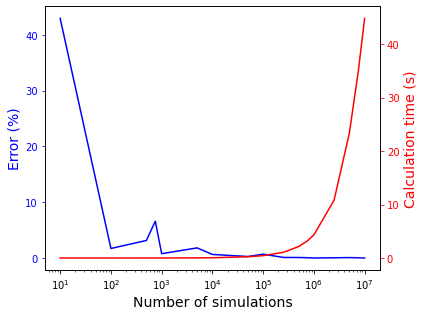

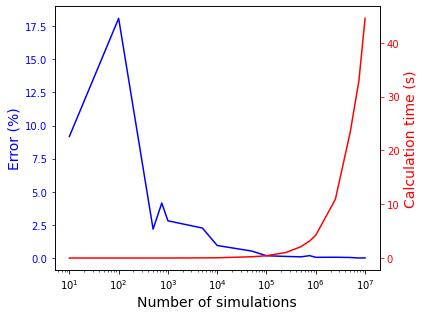

In [6]:
# Plot Error Vs Simulation number vs Calc time

# Binary Calls 
fig, ax1 = plt.subplots(figsize=(6,4.5))

ax1.semilogx(num_sims, # x-axis
             array_binary_call_errors, # y-axis
             'b-')
ax1.set_xlabel("Number of simulations", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Error (%)', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax2.semilogx(num_sims, # x-axis
             array_binary_call_times, # y-axis
             'r-')
ax2.set_ylabel('Calculation time (s)', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("binary_call_error_calc_times.eps")
plt.show()
plt.close()


# Binary Puts 
fig, ax1 = plt.subplots(figsize=(6,4.5))

ax1.semilogx(num_sims, # x-axis
             array_binary_put_errors, # y-axis
             'b-')
ax1.set_xlabel("Number of simulations", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Error (%)', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax2.semilogx(num_sims, # x-axis
             array_binary_put_times, # y-axis
             'r-')
ax2.set_ylabel('Calculation time (s)', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("binary_put_error_calc_times.eps")
plt.show()
plt.close()



In [7]:
# ==========================================
# METHODS FOR LOOKBACK FLOATING OPTIONS
# ==========================================

# I am going to explicitly code TWO methods
# for the call and put lookback options.

# Ideally, I would make one function for both
# for the sake of clarity but I want to be
# explicit.


def analytic_lookback_floating_call_value(S_0, Min, r, v, T):
    """
    Analytic solution of the Black-Scholes equation for a
    lookback floating CALL option
    
    I'm following the notation of 
    Wilmott (2007) Introduction to Quantitative Finance pg.268.
    
    NOTE: Min is the minimum asset price observed in the 
          history of the option.
    """
    d1 = calc_d1(S_0, Min, r, v, T)
    d2 = calc_d2(S_0, Min, r, v, T)
    d3 = calc_d3(S_0, Min, r, v, T)
    
    t1 = S_0 * norm.cdf(d1)
    t2 = Min * np.exp(-r*T) * norm.cdf(d2)
    t3 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
    t4 = math.pow((S_0/Min), ((-2.0*r)/(v*v))) * norm.cdf(d3) - np.exp(r*T)*norm.cdf(-d1)

    return t1 - t2 + (t3*t4)

def analytic_lookback_floating_put_value(S_0, Max, r, v, T):
    """
    Analytic solution of the Black-Scholes equation for a
    lookback floating PUT option
    
    I'm following the notation of 
    Wilmott (2007) Introduction to Quantitative Finance pg.268.
    
    NOTE: Max is the maximum asset price observed in the 
          history of the option.
    """
    d1 = calc_d1(S_0, Max, r, v, T)
    d2 = calc_d2(S_0, Max, r, v, T)
    d3 = calc_d3(S_0, Max, r, v, T)
    
    t1 = Max * np.exp(-r*T) * norm.cdf(-d2)
    t2 = S_0 * norm.cdf(-d1)
    t3 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
    t4 = -math.pow((S_0/Max), ((-2.0*r)/(v*v))) * norm.cdf(-d3) + np.exp(r*T)*norm.cdf(d1)
    
    return t1 - t2 + (t3*t4)

def calc_d1(S_0, H, r, v, T):
    """
    H could be the min/max of the option
    during its life
    """
    return (np.log(S_0/H) + (r + 0.5*v*v)*T) / (v*np.sqrt(T))

def calc_d2(S_0, H, r, v, T):
    return calc_d1(S_0, H, r, v, T) - v*np.sqrt(T)

def calc_d3(S_0, H, r, v, T):
    return -1.0*calc_d1(S_0, H, r, v, T) + (2.0 * r * np.sqrt(T) / v)

def monte_carlo_lookback_floating_call_value(N, S_0, r, v, time_range, dt, sqrtdt):
    """
    This method prices a lookback CALL option with 
    a floating strike using a Monte Carlo method.
    """
    option_life_data = np.zeros(shape=(len(time_range)), dtype=float)
    option_life_data[0] = S_0 # Stock price at the start of every simulation
    payoff_sum = 0.0
    S_min_sum = 0.0
    analytic_value_sum = 0.0
    payoffs = np.zeros(N)
    
    for j in range(0, N):
        S_min = 100000 # prescribe a dummy minimum

        for i in range(1, len(time_range)):
            # Calculate the underlying at each subsequent timestep
            option_life_data[i] = option_life_data[i-1] * np.exp(
                (r - 0.5*v*v)*dt + (v * sqrtdt * np.random.normal(0,1)))
        
        S_min = np.amin(option_life_data)      # Minimum price of underlying during 
                                               # the life of the option        
        S_T = option_life_data[-1]             # Price of underlying at maturity 
        payoff_sum += max(S_T - S_min, 0)
        S_min_sum += S_min
        
        payoffs[j] = max(S_T - S_min, 0)
        
        # Using Black-Scholes equation
        analytic_value_sum += analytic_lookback_floating_call_value(S0, S_min, r, sigma, T)
        
    average_payoff = (payoff_sum / N) * np.exp(-r*time_range[-1])
    return average_payoff, (analytic_value_sum / N), payoffs

def monte_carlo_lookback_floating_put_value(N, S_0, r, v, time_range, dt, sqrtdt):
    """
    This method prices a lookback PUT option with 
    a floating strike using a Monte Carlo method.
    """
    option_life_data = np.zeros(shape=(len(time_range)), dtype=float)
    option_life_data[0] = S_0 # Stock price at the start of every simulation
    payoff_sum = 0.0
    S_max_sum = 0.0
    analytic_value_sum = 0.0
    payoffs = np.zeros(N)
    
    for j in range(0, N):
        S_max = 0 # prescribe a dummy maximum

        for i in range(1, len(time_range)):
            # Calculate the underlying at each subsequent timestep
            option_life_data[i] = option_life_data[i-1] * np.exp(
                (r - 0.5*v*v)*dt + (v * sqrtdt * np.random.normal(0,1)))
        
        S_max = np.amax(option_life_data)      # Maximum price of underlying during 
                                               # the life of the option        
        S_T = option_life_data[-1]             # Price of underlying at maturity 
        payoff_sum += max(S_max - S_T, 0)
        S_max_sum += S_max
        
        payoffs[j] = max(S_max - S_T, 0)
        
        # Using Black-Scholes equation
        analytic_value_sum += analytic_lookback_floating_put_value(S0, S_max, r, sigma, T)
       
    average_payoff = (payoff_sum / N) * np.exp(-r*time_range[-1])
    return average_payoff, (analytic_value_sum / N), payoffs

In [8]:
# VARYING TIMESTEP LENGTH

# We are now going to test varying 
# the timestep length and its effect
# error and calculation time.

denominators = np.array([5, 10, 32, 64, 96, 126, 252, 300, 400, 500, 1000])
timesteps = 1.0/denominators

# Arrays for data storage and post-processing
# Lookback FLOATING options
array_lc_float_call_errors = np.zeros(len(timesteps))
array_lc_float_put_errors  = np.zeros(len(timesteps))

array_lc_float_call_times = np.zeros(len(timesteps))
array_lc_float_put_times  = np.zeros(len(timesteps))


In [9]:
# ==========================================
# CALCULATE European LOOKBACK FLOATING CALLs/PUTs 
# ==========================================
r = 0.05 
N =10000 # number of simulations
# We have selected 1e4 as our 
# number of simulations because 
# of the results from the binary
# call/put valuations after varying 
# number of simulations and finding 
# 1e5 is best trade-off between
# error and calculation time.

i=0
for dt in timesteps:
    sqrtdt = np.sqrt(dt)
    print("----------------------------------")
    print("                               timestep length:  %1.3f" % dt)

    time_range = np.arange(0, T+dt, dt) # array of time units

    # ------------------------------
    # Calculate Calls
    t0 = time.time()
    lookback_floating_call, lookback_floating_call_analytic, tmp = monte_carlo_lookback_floating_call_value(N, S0, r, 
                                                                      sigma, 
                                                                      time_range, 
                                                                      dt, sqrtdt)
    calc_time = time.time() - t0 # time of process
    array_lc_float_call_times[i] = calc_time # store calc time

    call_error = percentage_difference(lookback_floating_call, lookback_floating_call_analytic) # calc error from analytical
    array_lc_float_call_errors[i] = call_error # store error
    print("Lookback floating CALL option value(Numerical): £%3.4f" % lookback_floating_call)
    print("Lookback floating CALL option value (Analytic): £%3.4f\n" % lookback_floating_call_analytic)
    print("                              Calculation time:  %2.4f s\n" % calc_time)


    # ------------------------------
    # Calculate Puts
    t0 = time.time()
    lookback_floating_put, lookback_floating_put_analytic, tmp  = monte_carlo_lookback_floating_put_value(N, S0, r, 
                                                                      sigma, 
                                                                      time_range, 
                                                                      dt, sqrtdt)
    calc_time = time.time() - t0 # time of process
    array_lc_float_put_times[i] = calc_time # store calc time

    put_error = percentage_difference(lookback_floating_put, lookback_floating_put_analytic) # calc error from analytical
    array_lc_float_put_errors[i] = put_error # store error
    print("Lookback floating  PUT option value(Numerical): £%3.4f" % lookback_floating_put)
    print("Lookback floating  PUT option value (Analytic): £%3.4f\n" % lookback_floating_put_analytic)
    print("                              Calculation time:  %2.4f s" % calc_time)
    print("\n\n")

    i+=1

----------------------------------
                               timestep length:  0.200
Lookback floating CALL option value(Numerical): £13.7369
Lookback floating CALL option value (Analytic): £20.5846

                              Calculation time:  3.7999 s

Lookback floating  PUT option value(Numerical): £9.3171
Lookback floating  PUT option value (Analytic): £20.1032

                              Calculation time:  3.8047 s



----------------------------------
                               timestep length:  0.100
Lookback floating CALL option value(Numerical): £14.6680
Lookback floating CALL option value (Analytic): £21.0260

                              Calculation time:  3.9583 s

Lookback floating  PUT option value(Numerical): £10.5919
Lookback floating  PUT option value (Analytic): £20.7779

                              Calculation time:  4.0024 s



----------------------------------
                               timestep length:  0.031
Lookback floating CALL option v

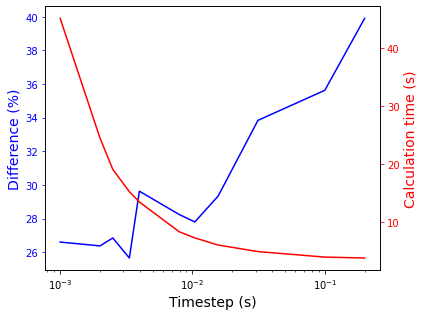

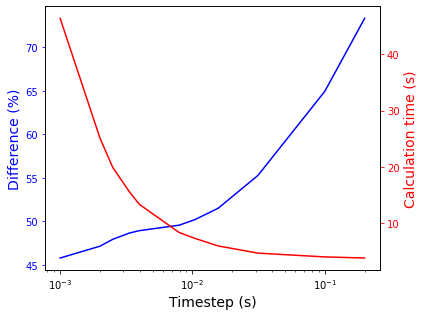

In [10]:
# Plot Error Vs Simulation number vs Calc time

# LB FLOATING Calls 
fig, ax1 = plt.subplots(figsize=(6,4.5))

ax1.semilogx(timesteps, # x-axis
             array_lc_float_call_errors, # y-axis
             'b-')
ax1.set_xlabel("Timestep (s)", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Difference (%)', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax2.semilogx(timesteps, # x-axis
             array_lc_float_call_times, # y-axis
             'r-')
ax2.set_ylabel('Calculation time (s)', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("lb_float_call_error_calc_times.eps")
plt.show()
plt.close()


# Binary Puts 
fig, ax1 = plt.subplots(figsize=(6,4.5))

ax1.semilogx(timesteps, # x-axis
             array_lc_float_put_errors, # y-axis
             'b-')
ax1.set_xlabel("Timestep (s)", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Difference (%)', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax2.semilogx(timesteps, # x-axis
             array_lc_float_put_times, # y-axis
             'r-')
ax2.set_ylabel('Calculation time (s)', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("lb_float_put_error_calc_times.eps")
plt.show()
plt.close()


In [11]:
# ==========================================
# METHODS FOR LOOKBACK FIXED OPTIONS
# ==========================================

# I am going to explicitly code TWO methods
# for the call and put lookback options.

# Ideally, I would make one function for both
# for the sake of clarity but I want to be
# explicit.

def analytic_lookback_fixed_call_value(S_0, E, Max, r, v, T):
    """
    Analytic solution of the Black-Scholes equation for a
    lookback fixed CALL option
    
    I'm following the notation of 
    Wilmott (2007) Introduction to Quantitative Finance pg.269.
    
    NOTE: Max is the minimum asset price observed in the 
          history of the option.
    """
    
    if E > Max:
        d1 = calc_d1(S_0, E, r, v, T)
        d2 = calc_d1(S_0, E, r, v, T)
        d3 = calc_d1(S_0, E, r, v, T)
        
        t1 = S_0 * norm.cdf(d1)
        t2 = E * np.exp(-r*T) * norm.cdf(d2)
        t3 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
        t4 = -math.pow((S_0/E), ((-2.0*r)/(v*v))) * norm.cdf(-d3) + np.exp(r*T)*norm.cdf(d1)
        
        return t1 - t2 + (t3*t4)
        
    elif E <= Max:
        d1 = calc_d1(S_0, Max, r, v, T)
        d2 = calc_d2(S_0, Max, r, v, T)
        d3 = calc_d3(S_0, Max, r, v, T)

        t1 = (Max - E) * np.exp(-r*T)
        t2 = S_0 * norm.cdf(d1)
        t3 = Max * np.exp(-r*T) * norm.cdf(d2)
        t4 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
        t5 = -math.pow((S_0/Max), ((-2.0*r)/(v*v))) * norm.cdf(-d3) + np.exp(r*T)*norm.cdf(d1)

        return t1 + t2 - t3 + t4*t5
    

def analytic_lookback_fixed_put_value(S_0, E, Min, r, v, T):
    """
    Analytic solution of the Black-Scholes equation for a
    lookback floating PUT option
    
    I'm following the notation of 
    Wilmott (2007) Introduction to Quantitative Finance pg.269-270.
    
    NOTE: Min is the maximum asset price observed in the 
          history of the option.
    """

    if E < Min:
        d1 = calc_d1(S_0, E, r, v, T)
        d2 = calc_d1(S_0, E, r, v, T)
        d3 = calc_d1(S_0, E, r, v, T)
        
        t1 = E * np.exp(-r*T) * norm.cdf(-d2)
        t2 = S_0 * norm.cdf(-d1)
        t3 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
        t4 = math.pow((S_0/E), ((-2.0*r)/(v*v))) * norm.cdf(d3) - np.exp(r*T)*norm.cdf(-d1)
    
        return t1 - t2 + (t3*t4)
    
    elif E >= Min:
        d1 = calc_d1(S_0, Min, r, v, T)
        d2 = calc_d2(S_0, Min, r, v, T)
        d3 = calc_d3(S_0, Min, r, v, T)

        t1 = (E - Min) * np.exp(-r*T)
        t2 = S_0 * norm.cdf(-d1)
        t3 = Min * np.exp(-r*T) * norm.cdf(-d2)
        t4 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
        t5 = math.pow((S_0/Min), ((-2.0*r)/(v*v))) * norm.cdf(d3) - np.exp(r*T)*norm.cdf(-d1)

        return t1 - t2 + t3 + t4*t5

def monte_carlo_lookback_fixed_call_value(N, S_0, E, r, v, time_range, dt, sqrtdt):
    """
    This method prices a lookback CALL option with 
    a fixed strike using a Monte Carlo method.
    """
    option_life_data = np.zeros(shape=(len(time_range)), dtype=float)
    option_life_data[0] = S_0 # Stock price at the start of every simulation
    payoff_sum = 0.0
    analytic_value_sum = 0.0
    payoffs = np.zeros(N)
    
    for j in range(0, N):
        S_max = 0 # prescribe a dummy maximum

        for i in range(1, len(time_range)):
            # Calculate the underlying at each subsequent timestep
            option_life_data[i] = option_life_data[i-1] * np.exp(
                (r - 0.5*v*v)*dt + (v * sqrtdt * np.random.normal(0,1)))
        
        S_max = np.amax(option_life_data)      # Maximum price of underlying during 
                                               # the life of the option
        payoff_sum += max(S_max - E, 0)
        payoffs[j] = max(S_max - E, 0)
        
        # Using Black-Scholes equation
        analytic_value_sum += analytic_lookback_fixed_call_value(S0, E, S_max, r, sigma, T)
       
    
    average_payoff = (payoff_sum / N) * np.exp(-r*time_range[-1])
    return average_payoff, (analytic_value_sum/N), payoffs

def monte_carlo_lookback_fixed_put_value(N, S_0, E, r, v, time_range, dt, sqrtdt):
    """
    This method prices a lookback PUT option with 
    a fixed strike using a Monte Carlo method.
    """
    option_life_data = np.zeros(shape=(len(time_range)), dtype=float)
    option_life_data[0] = S_0 # Stock price at the start of every simulation
    payoff_sum = 0.0
    analytic_value_sum = 0.0
    payoffs = np.zeros(N)
    
    for j in range(0, N):
        S_min = 100000 # prescribe a dummy minimum

        for i in range(1, len(time_range)):
            # Calculate the underlying at each subsequent timestep
            option_life_data[i] = option_life_data[i-1] * np.exp(
                (r - 0.5*v*v)*dt + (v * sqrtdt * np.random.normal(0,1)))
        
        S_min = np.amin(option_life_data)      # Minimum price of underlying during 
                                               # the life of the option
        payoff_sum += max(E - S_min, 0)
        payoffs[j] = max(E - S_min, 0)
        
        # Using Black-Scholes equation
        analytic_value_sum += analytic_lookback_fixed_put_value(S0, E, S_min, r, sigma, T)
       
    
    average_payoff = (payoff_sum / N) * np.exp(-r*time_range[-1])
    return average_payoff, (analytic_value_sum/N), payoffs

In [12]:
# Varying interest rates

# Constant risk-free interest rate 
interest_rates = np.array([ 0.0,
                            0.001,
                            0.0025,
                            0.005,
                            0.0075,
                            0.01,
                            0.02,
                            0.03,
                            0.04,
                             0.05, # Fixed interest rate
                            0.075,
                            0.10,
                           ])

N = 10000
T = 1                      # number of years
time_units = 252.0         # days in a working year
dt = (T - 0)/time_units   # timestep
sqrtdt = np.sqrt(dt)       # Compute this outside the loop to save computing it 
                           # at every timestep
time_range = np.arange(0, T+dt, dt)   # array of time units



# Initialise arrays for storage for post-processing


# complete data for binary calls
data_binary_call = np.zeros((len(interest_rates), N))
data_binary_put  = np.zeros((len(interest_rates), N))

data_lb_float_call = np.zeros((len(interest_rates), N))
data_lb_float_put  = np.zeros((len(interest_rates), N))

data_lb_fixed_call = np.zeros((len(interest_rates), N))
data_lb_fixed_put  = np.zeros((len(interest_rates), N))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


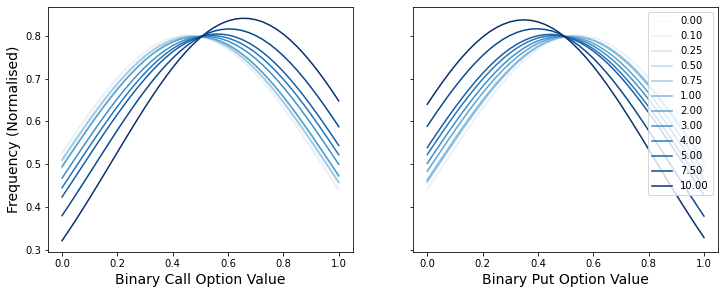

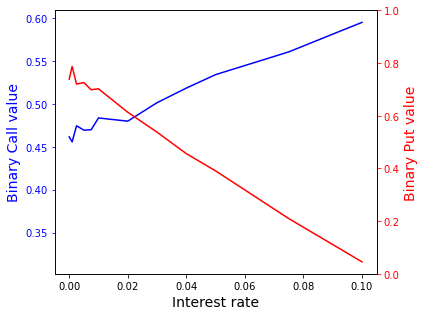

In [13]:
# ==========================================
# Vary IRs: BINARY
# ==========================================
rates_vs_calls = np.zeros(shape=(len(interest_rates)))
rates_vs_puts = np.zeros(shape=(len(interest_rates)))


# Plot PDFs
fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)
colours = plt.cm.Blues(np.linspace(0.0, 1.0, len(interest_rates)))

i=0
for r in interest_rates:
    binary_call, data_binary_call[i,:] = monte_carlo_binary_call_value(N, S0, E, r, sigma, T) # calculation
    binary_put, data_binary_put[i,:]  = monte_carlo_binary_put_value(N, S0, E, r, sigma, T) # calculation    

    rates_vs_calls[i] = binary_call
    rates_vs_puts[i]  = binary_put
    
    n_bins = 40 
    # CALLS
    min_value = np.amin(data_binary_call[i, :])
    max_value = np.amax(data_binary_call[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_binary_call[i,:])
    sims_stdv = np.std(data_binary_call[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(r*100.0)
    ax[0].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)

    
    
    # PUTS
    min_value = np.amin(data_binary_put[i, :])
    max_value = np.amax(data_binary_put[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_binary_put[i,:])
    sims_stdv = np.std(data_binary_put[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(r*100.0)
    ax[1].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)
    
    i+=1

ax[0].set_xlabel("Binary Call Option Value", fontsize=14)
ax[0].set_ylabel("Frequency (Normalised)", fontsize=14)

ax[1].set_xlabel("Binary Put Option Value", fontsize=14)
ax[1].legend(loc='upper right')

plt.savefig("binary_pdf.eps")
plt.show()
plt.close()






# Plot prices against IR    
fig, ax1 = plt.subplots(figsize=(6,4.5))
ax1.plot(interest_rates,
         rates_vs_calls,
         'b-')

ax1.set_xlabel("Interest rate", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Binary Call value', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax1.plot(interest_rates,
         rates_vs_puts,
         'r-')

ax2.set_ylabel('Binary Put value', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("binary_vs_interest_rates.eps")
plt.show()
plt.close()

0.0


<ipython-input-7-744b3c001d1e>:30: RuntimeWarning: divide by zero encountered in double_scalars
  t3 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
<ipython-input-7-744b3c001d1e>:33: RuntimeWarning: invalid value encountered in double_scalars
  return t1 - t2 + (t3*t4)
<ipython-input-7-744b3c001d1e>:52: RuntimeWarning: divide by zero encountered in double_scalars
  t3 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
<ipython-input-7-744b3c001d1e>:55: RuntimeWarning: invalid value encountered in double_scalars
  return t1 - t2 + (t3*t4)


29.392817974090576
0.001
29.90899109840393
0.0025
28.990445137023926
0.005
28.71121120452881
0.0075
29.231725692749023
0.01
29.00530481338501
0.02
29.201220989227295
0.03
29.149121046066284
0.04
30.80026912689209
0.05
29.33301830291748
0.075
29.013569116592407
0.1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


28.339147090911865


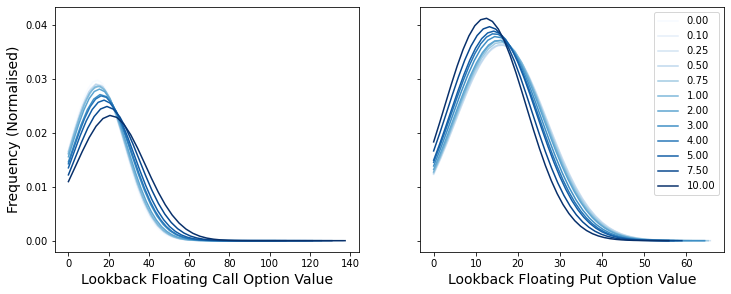

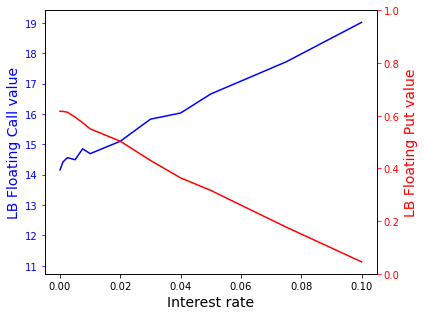

In [14]:
rates_vs_calls = np.zeros(shape=(len(interest_rates)))
rates_vs_puts = np.zeros(shape=(len(interest_rates)))



N = 10000
T = 1                      # number of years
time_units = 252.0         # days in a working year
dt = (T - 0)/time_units   # timestep
sqrtdt = np.sqrt(dt)       # Compute this outside the loop to save computing it 
                           # at every timestep
time_range = np.arange(0, T+dt, dt)   # array of time units


# Plot PDFs

fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)
colours = plt.cm.Blues(np.linspace(0.0, 1.0, len(interest_rates)))

i=0
for r in interest_rates:
    print(r)
    start=time.time()
    # ------------------------------ LOOKBACK FLOATING
    lookback_floating_call, lookback_floating_call_analytic, data_lb_float_call[i,:] = monte_carlo_lookback_floating_call_value(N, S0, r, 
                                                                      sigma, 
                                                                      time_range, 
                                                                      dt, sqrtdt)
    lookback_floating_put, lookback_floating_put_analytic, data_lb_float_put[i,:]  = monte_carlo_lookback_floating_put_value(N, S0, r, 
                                                                      sigma, 
                                                                      time_range, 
                                                                      dt, sqrtdt)
    rates_vs_calls[i] = lookback_floating_call
    rates_vs_puts[i]  = lookback_floating_put

    
    n_bins = 40 
    # CALLS
    min_value = np.amin(data_lb_float_call[i, :])
    max_value = np.amax(data_lb_float_call[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_float_call[i,:])
    sims_stdv = np.std(data_lb_float_call[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(r*100.0)
    ax[0].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)

    
    
    # PUTS
    min_value = np.amin(data_lb_float_put[i, :])
    max_value = np.amax(data_lb_float_put[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_float_put[i,:])
    sims_stdv = np.std(data_lb_float_put[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(r*100.0)
    ax[1].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)
    print(time.time() - start)
    i+=1

ax[0].set_xlabel("Lookback Floating Call Option Value", fontsize=14)
ax[0].set_ylabel("Frequency (Normalised)", fontsize=14)

ax[1].set_xlabel("Lookback Floating Put Option Value", fontsize=14)
ax[1].legend(loc='upper right')

plt.savefig("lb_float_pdf.eps")
plt.show()
plt.close()




# Plot prices against IR  
fig, ax1 = plt.subplots(figsize=(6,4.5))
ax1.plot(interest_rates,
         rates_vs_calls,
         'b-')

ax1.set_xlabel("Interest rate", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('LB Floating Call value', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax1.plot(interest_rates,
         rates_vs_puts,
         'r-')

ax2.set_ylabel('LB Floating Put value', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("lb_floating_vs_interest_rates.eps")
plt.show()
plt.close()

In [ ]:
rates_vs_calls = np.zeros(shape=(len(interest_rates)))
rates_vs_puts = np.zeros(shape=(len(interest_rates)))

fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)
colours = plt.cm.Blues(np.linspace(0.0, 1.0, len(interest_rates)))

i=0
for r in interest_rates:
    print(r)
    start=time.time()
    # ------------------------------ LOOKBACK FIXED
    lookback_fixed_call, lookback_fixed_call_analytic, data_lb_fixed_call[i,:] = monte_carlo_lookback_fixed_call_value(N, S0, E, r, sigma, time_range, dt, sqrtdt)
    lookback_fixed_put, lookback_fixed_put_analytic, data_lb_fixed_put[i,:]    = monte_carlo_lookback_fixed_put_value( N, S0, E, r, sigma, time_range, dt, sqrtdt)
    
    rates_vs_calls[i] = lookback_fixed_call
    rates_vs_puts[i]  = lookback_fixed_put 

    
    n_bins = 40 
    # CALLS
    min_value = np.amin(data_lb_fixed_call[i, :])
    max_value = np.amax(data_lb_fixed_call[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_fixed_call[i,:])
    sims_stdv = np.std(data_lb_fixed_call[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(r*100.0)
    ax[0].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)

    
    
    # PUTS
    min_value = np.amin(data_lb_fixed_put[i, :])
    max_value = np.amax(data_lb_fixed_put[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_fixed_put[i,:])
    sims_stdv = np.std(data_lb_fixed_put[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(r*100.0)
    ax[1].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)
    print(time.time() - start)
    i+=1

ax[0].set_xlabel("Lookback Fixed Call Option Value", fontsize=14)
ax[0].set_ylabel("Frequency (Normalised)", fontsize=14)

ax[1].set_xlabel("Lookback Fixed Put Option Value", fontsize=14)
ax[1].legend(loc='upper right')

plt.savefig("lb_fixed_pdf.eps")
plt.show()
plt.close()



    
fig, ax1 = plt.subplots(figsize=(6,4.5))
ax1.plot(interest_rates,
         rates_vs_calls,
         'b-')

ax1.set_xlabel("Interest rate", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('LB Fixed Call value', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax1.plot(interest_rates,
         rates_vs_puts,
         'r-')

ax2.set_ylabel('LB Fixed Put value', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("lb_fixed_vs_interest_rates.eps")
plt.show()
plt.close()

0.0


<ipython-input-11-faee834221eb>:44: RuntimeWarning: divide by zero encountered in double_scalars
  t4 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
<ipython-input-11-faee834221eb>:47: RuntimeWarning: invalid value encountered in double_scalars
  return t1 + t2 - t3 + t4*t5
<ipython-input-11-faee834221eb>:82: RuntimeWarning: divide by zero encountered in double_scalars
  t4 = S_0 * np.exp(-r*T) * ((v*v) / (2.0*r))
<ipython-input-11-faee834221eb>:85: RuntimeWarning: invalid value encountered in double_scalars
  return t1 - t2 + t3 + t4*t5


In [ ]:
# ==========================================
# Varying volatility
# ==========================================
# Constant risk-free interest rate 
sigmas = np.array([ 0.0,
                    0.05, 
                    0.10, 
                    0.15,
                    0.20,
                    0.25,
                    0.3,
                    0.4, 
                   0.5, 
                   0.6, 
                   0.8, 
                   1.0, 
                   1.5, 
                   2.0])
r = 0.05
N = 10000
T = 1                      # number of years
time_units = 252.0         # days in a working year
dt = (T - 0)/time_units   # timestep
sqrtdt = np.sqrt(dt)       # Compute this outside the loop to save computing it 
                           # at every timestep
time_range = np.arange(0, T+dt, dt)   # array of time units



# Initialise arrays for storage for post-processing


# complete data for binary calls
data_binary_call = np.zeros((len(sigmas), N))
data_binary_put  = np.zeros((len(sigmas), N))

data_lb_float_call = np.zeros((len(sigmas), N))
data_lb_float_put  = np.zeros((len(sigmas), N))

data_lb_fixed_call = np.zeros((len(sigmas), N))
data_lb_fixed_put  = np.zeros((len(sigmas), N))

In [ ]:
rates_vs_calls = np.zeros(shape=(len(sigmas)))
rates_vs_puts = np.zeros(shape=(len(sigmas)))

fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)
colours = plt.cm.Reds(np.linspace(0.0, 1.0, len(sigmas)))

i=0
for sigma in sigmas:
    binary_call, data_binary_call[i,:] = monte_carlo_binary_call_value(N, S0, E, r, sigma, T) # calculation
    binary_put, data_binary_put[i,:]  = monte_carlo_binary_put_value(N, S0, E, r, sigma, T) # calculation    

    rates_vs_calls[i] = binary_call
    rates_vs_puts[i]  = binary_put
    
    n_bins = 40 
    # CALLS
    min_value = np.amin(data_binary_call[i, :])
    max_value = np.amax(data_binary_call[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_binary_call[i,:])
    sims_stdv = np.std(data_binary_call[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(sigma*100.0)
    ax[0].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)

    
    
    # PUTS
    min_value = np.amin(data_binary_put[i, :])
    max_value = np.amax(data_binary_put[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_binary_put[i,:])
    sims_stdv = np.std(data_binary_put[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.2f"%(sigma*100.0)
    ax[1].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)
    
    i+=1

ax[0].set_xlabel("Binary Call Option Value", fontsize=14)
ax[0].set_ylabel("Frequency (Normalised)", fontsize=14)

ax[1].set_xlabel("Binary Put Option Value", fontsize=14)
ax[1].legend(loc='upper right')

plt.savefig("binary_sigma_pdf.eps")
plt.show()
plt.close()



    
    
fig, ax1 = plt.subplots(figsize=(6,4.5))
ax1.plot(sigmas,
         rates_vs_calls,
         'b-')

ax1.set_xlabel("Volatility", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Binary Call value', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax1.plot(sigmas,
         rates_vs_puts,
         'r-')

ax2.set_ylabel('Binary Put value', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("binary_vs_volatilities.eps")
plt.show()
plt.close()

In [ ]:
rates_vs_calls = np.zeros(shape=(len(sigmas)))
rates_vs_puts = np.zeros(shape=(len(sigmas)))



N = 10000
T = 1                      # number of years
time_units = 252.0         # days in a working year
dt = (T - 0)/time_units   # timestep
sqrtdt = np.sqrt(dt)       # Compute this outside the loop to save computing it 
                           # at every timestep
time_range = np.arange(0, T+dt, dt)   # array of time units


fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)
colours = plt.cm.Reds(np.linspace(0.0, 1.0, len(sigmas)))


i=0
for sigma in sigmas:
    print(sigma)
    start=time.time()
    # ------------------------------ LOOKBACK FLOATING
    lookback_floating_call, lookback_floating_call_analytic, data_lb_float_call[i,:] = monte_carlo_lookback_floating_call_value(N, S0, r, 
                                                                      sigma, 
                                                                      time_range, 
                                                                      dt, sqrtdt)
    lookback_floating_put, lookback_floating_put_analytic, data_lb_float_put[i,:]  = monte_carlo_lookback_floating_put_value(N, S0, r, 
                                                                      sigma, 
                                                                      time_range, 
                                                                      dt, sqrtdt)
    rates_vs_calls[i] = lookback_floating_call
    rates_vs_puts[i]  = lookback_floating_put

    
    n_bins = 40 
    # CALLS
    min_value = np.amin(data_lb_float_call[i, :])
    max_value = np.amax(data_lb_float_call[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_float_call[i,:])
    sims_stdv = np.std(data_lb_float_call[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.0f"%(sigma*100.0)
    ax[0].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)

    
    
    # PUTS
    min_value = np.amin(data_lb_float_put[i, :])
    max_value = np.amax(data_lb_float_put[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_float_put[i,:])
    sims_stdv = np.std(data_lb_float_put[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.0f"%(sigma*100.0)
    ax[1].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)
    print(time.time() - start)
    i+=1

ax[0].set_xlabel("Lookback Floating Call Option Value", fontsize=14)
ax[0].set_ylabel("Frequency (Normalised)", fontsize=14)

ax[1].set_xlabel("Lookback Floating Put Option Value", fontsize=14)
ax[1].legend(loc='upper right')

ax[0].set_xlim([0,150])
ax[1].set_xlim([0,150])

plt.savefig("lb_float_sigma_pdf.eps")
plt.show()
plt.close()



    
fig, ax1 = plt.subplots(figsize=(6,4.5))
ax1.plot(sigmas,
         rates_vs_calls,
         'b-')

ax1.set_xlabel("Volatility", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('LB Floating Call value', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax1.plot(sigmas,
         rates_vs_puts,
         'r-')

ax2.set_ylabel('LB Floating Put value', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("lb_floating_vs_volatilities.eps")
plt.show()
plt.close()

In [ ]:
rates_vs_calls = np.zeros(shape=(len(sigmas)))
rates_vs_puts = np.zeros(shape=(len(sigmas)))

fig, ax = plt.subplots(1, 2, figsize=(12,4.5), sharey=True)
colours = plt.cm.Reds(np.linspace(0.0, 1.0, len(sigmas)))


i=0
for sigma in sigmas:
    print(sigma)
    start=time.time()
    # ------------------------------ LOOKBACK FIXED
    lookback_fixed_call, lookback_fixed_call_analytic, data_lb_fixed_call[i,:] = monte_carlo_lookback_fixed_call_value(N, S0, E, r, sigma, time_range, dt, sqrtdt)
    lookback_fixed_put, lookback_fixed_put_analytic, data_lb_fixed_put[i,:]    = monte_carlo_lookback_fixed_put_value( N, S0, E, r, sigma, time_range, dt, sqrtdt)
    
    rates_vs_calls[i] = lookback_fixed_call
    rates_vs_puts[i]  = lookback_fixed_put  

    
    n_bins = 40 
    # CALLS
    min_value = np.amin(data_lb_fixed_call[i, :])
    max_value = np.amax(data_lb_fixed_call[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_fixed_call[i,:])
    sims_stdv = np.std(data_lb_fixed_call[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.0f"%(sigma*100.0)
    ax[0].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)

    
    
    # PUTS
    min_value = np.amin(data_lb_fixed_put[i, :])
    max_value = np.amax(data_lb_fixed_put[i, :])
    d_bin = (max_value - min_value)/n_bins
    bins = np.arange(min_value, max_value+d_bin, d_bin)

    sims_mean = np.average(data_lb_fixed_put[i,:])
    sims_stdv = np.std(data_lb_fixed_put[i,:])

    y = ((1.0 / (np.sqrt(2.0 * np.pi) * sims_stdv)) * np.exp(-0.5 * (1.0 / sims_stdv * (bins - sims_mean))**2))
    legend_label= "%2.0f"%(sigma*100.0)
    ax[1].plot(bins, y, linestyle="-", color=colours[i], label=legend_label)
    print(time.time() - start)
    i+=1

ax[0].set_xlabel("Lookback Fixed Call Option Value", fontsize=14)
ax[0].set_ylabel("Frequency (Normalised)", fontsize=14)

ax[1].set_xlabel("Lookback Fixed Put Option Value", fontsize=14)
ax[1].legend(loc='upper right')

ax[0].set_xlim([0,100])
ax[1].set_xlim([0,100])

plt.savefig("lb_fixed_sigma_pdf.eps")
plt.show()
plt.close()




    
fig, ax1 = plt.subplots(figsize=(6,4.5))
ax1.plot(sigmas,
         rates_vs_calls,
         'b-')

ax1.set_xlabel("Volatility", fontsize=14)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('LB Fixed Call value', color='b', fontsize=14)
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax1.plot(sigmas,
         rates_vs_puts,
         'r-')

ax2.set_ylabel('LB Fixed Put value', color='r', fontsize=14)
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.savefig("lb_fixed_vs_volatilities.eps")
plt.show()
plt.close()
